In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from matplotlib.pyplot import figure
import glob

In [2]:
dataset_metadata = { 'yelp': {"train_size": 30400, "val_size": 3800, 'metric': 'acc', 'coverage': 0.83}, 
                     'imdb': {"train_size": 20000, "val_size": 2500, 'metric': 'acc', 'coverage': 0.88},
                     'trec': {"train_size": 4800, "val_size": 500, 'metric': 'acc', 'coverage': 0.95},
                     'youtube': {"train_size": 2000, "val_size": 120, 'metric': 'acc', 'coverage': 0.87},
                     'chemprot': {"train_size": 12600, "val_size": 1607, 'metric': 'acc', 'coverage': 0.86},
                     'spouse': {"train_size": 22254, "val_size": 2811, 'metric': 'f1_binary', 'coverage': 0.25 },
                     'cdr': {"train_size": 8430, "val_size": 920, 'metric': 'f1_binary', 'coverage': 0.907 }
                   }
result_directory = "results"
datasets = ['youtube', 'cdr', 'chemprot', 'trec']
N_RUNS = 5
PERCENT_TRIAL = 5
label_models = ['majority_voting', 'snorkel', 'val_as_train', 'dawid_skene', 'flying_squid']
end_models = ['bert', 'cosine']
LM_to_color = { 'majority_voting': 'blue', 
                'snorkel': 'orange',
                'val_as_train': 'black',
                'generative_model': 'green',
                'flying_squid': 'red',
                'dawid_skene': 'purple'}
EM_to_color = {'bert_cosine' : 'pink', 'oracle': 'gold'}
label_types = ['hard', 'soft']

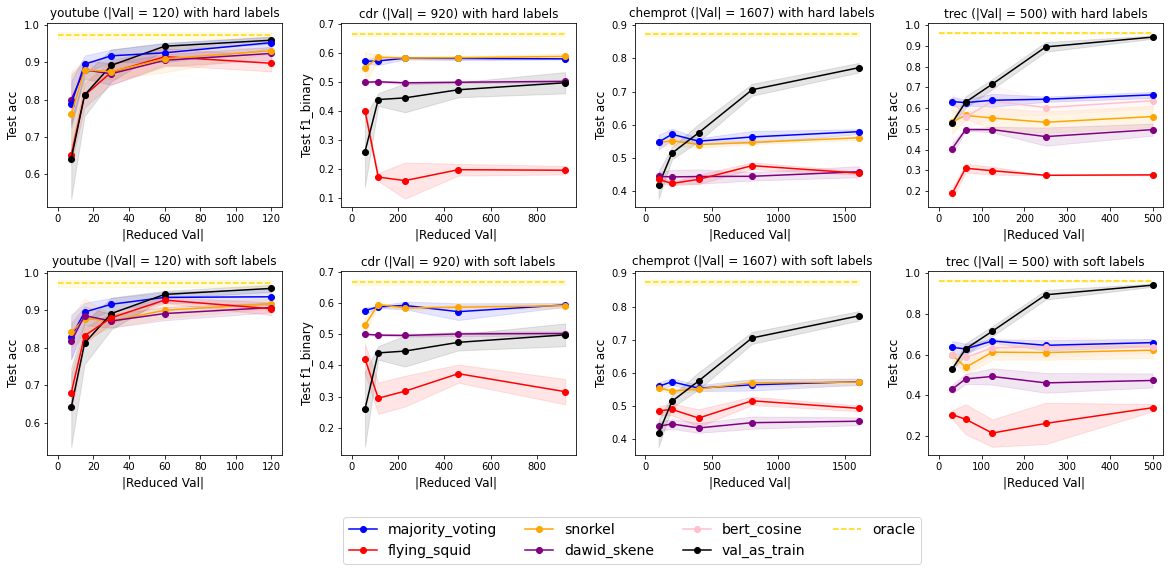

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(20,8))
counter_x = 0
counter_y = 0
for label_type in label_types:
    for data in datasets:
        files_per_data = glob.glob(f'BERT/*.json')
        ax = axs[counter_y, counter_x]
        counter_x += 1
        if counter_x == 4:
            counter_x = 0
            counter_y += 1
        for filepath in files_per_data:
            with open(filepath) as f:
                file =  filepath.split("/")[1].split('.')[0].split("-")
                if file[1] == "oracle":
                    continue
                if file[0] == "old":
                    dataset_name = file[1]
                    LM = file[3]
                    EM = file[4]
                    cur_type = label_type
                else:
                    dataset_name, pip ,LM, EM, cur_type = file
                if label_type != cur_type or dataset_name != data:
                    continue
                result_dict = json.load(f)
                x = result_dict.keys()
                em_test = [result_dict[k]["em_test"] for  k in result_dict]
                em_test_mean, em_test_std = zip(*[list(v.values())[0] for v in em_test])
                em_test_se = np.array(em_test_std) / np.sqrt(N_RUNS)
                x = np.array(list(x)).astype(float) * dataset_metadata[data]['val_size']
                if EM == 'bert_cosine':
                    la = EM
                    co = EM_to_color[EM]
                else:
                    la = LM
                    co = LM_to_color[LM]
                ax.plot(x, em_test_mean, label = la, color = co, marker='o')
                ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color = co)
        for filepath in files_per_data:
            with open(filepath) as f:
                file =  filepath.split("/")[1].split('.')[0].split("-")
                if file[1] != "oracle" or file[0] != data:
                    continue
                dataset_name, pip ,LM, EM = file
                result_dict = json.load(f)
                x = result_dict.keys()
                em_test_mean, em_test_std = list(result_dict["em_test"].values())[0]
                em_test_mean = np.repeat(em_test_mean, PERCENT_TRIAL)
                em_test_se = np.repeat(em_test_std, PERCENT_TRIAL) / np.sqrt(N_RUNS)
                x = np.linspace(0, dataset_metadata[data]['val_size'], PERCENT_TRIAL)
                ax.plot(x, em_test_mean, label =pip, color = EM_to_color[pip], linestyle='dashed')
                ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color = EM_to_color[pip])
        ax.set_title(f"{data} (|Val| = {dataset_metadata[data]['val_size']}) with {label_type} labels", fontsize=12)
        ax.set_xlabel("|Reduced Val| ", fontsize=12)
        ax.set_ylabel("Test {}".format(dataset_metadata[data]['metric']), fontsize=12)
plt.legend(ncol=4, bbox_to_anchor=(0,-0.3), fontsize = 14)
plt.subplots_adjust(bottom=0.25, top=1.0, hspace=0.35, wspace=0.25)
plt.show()